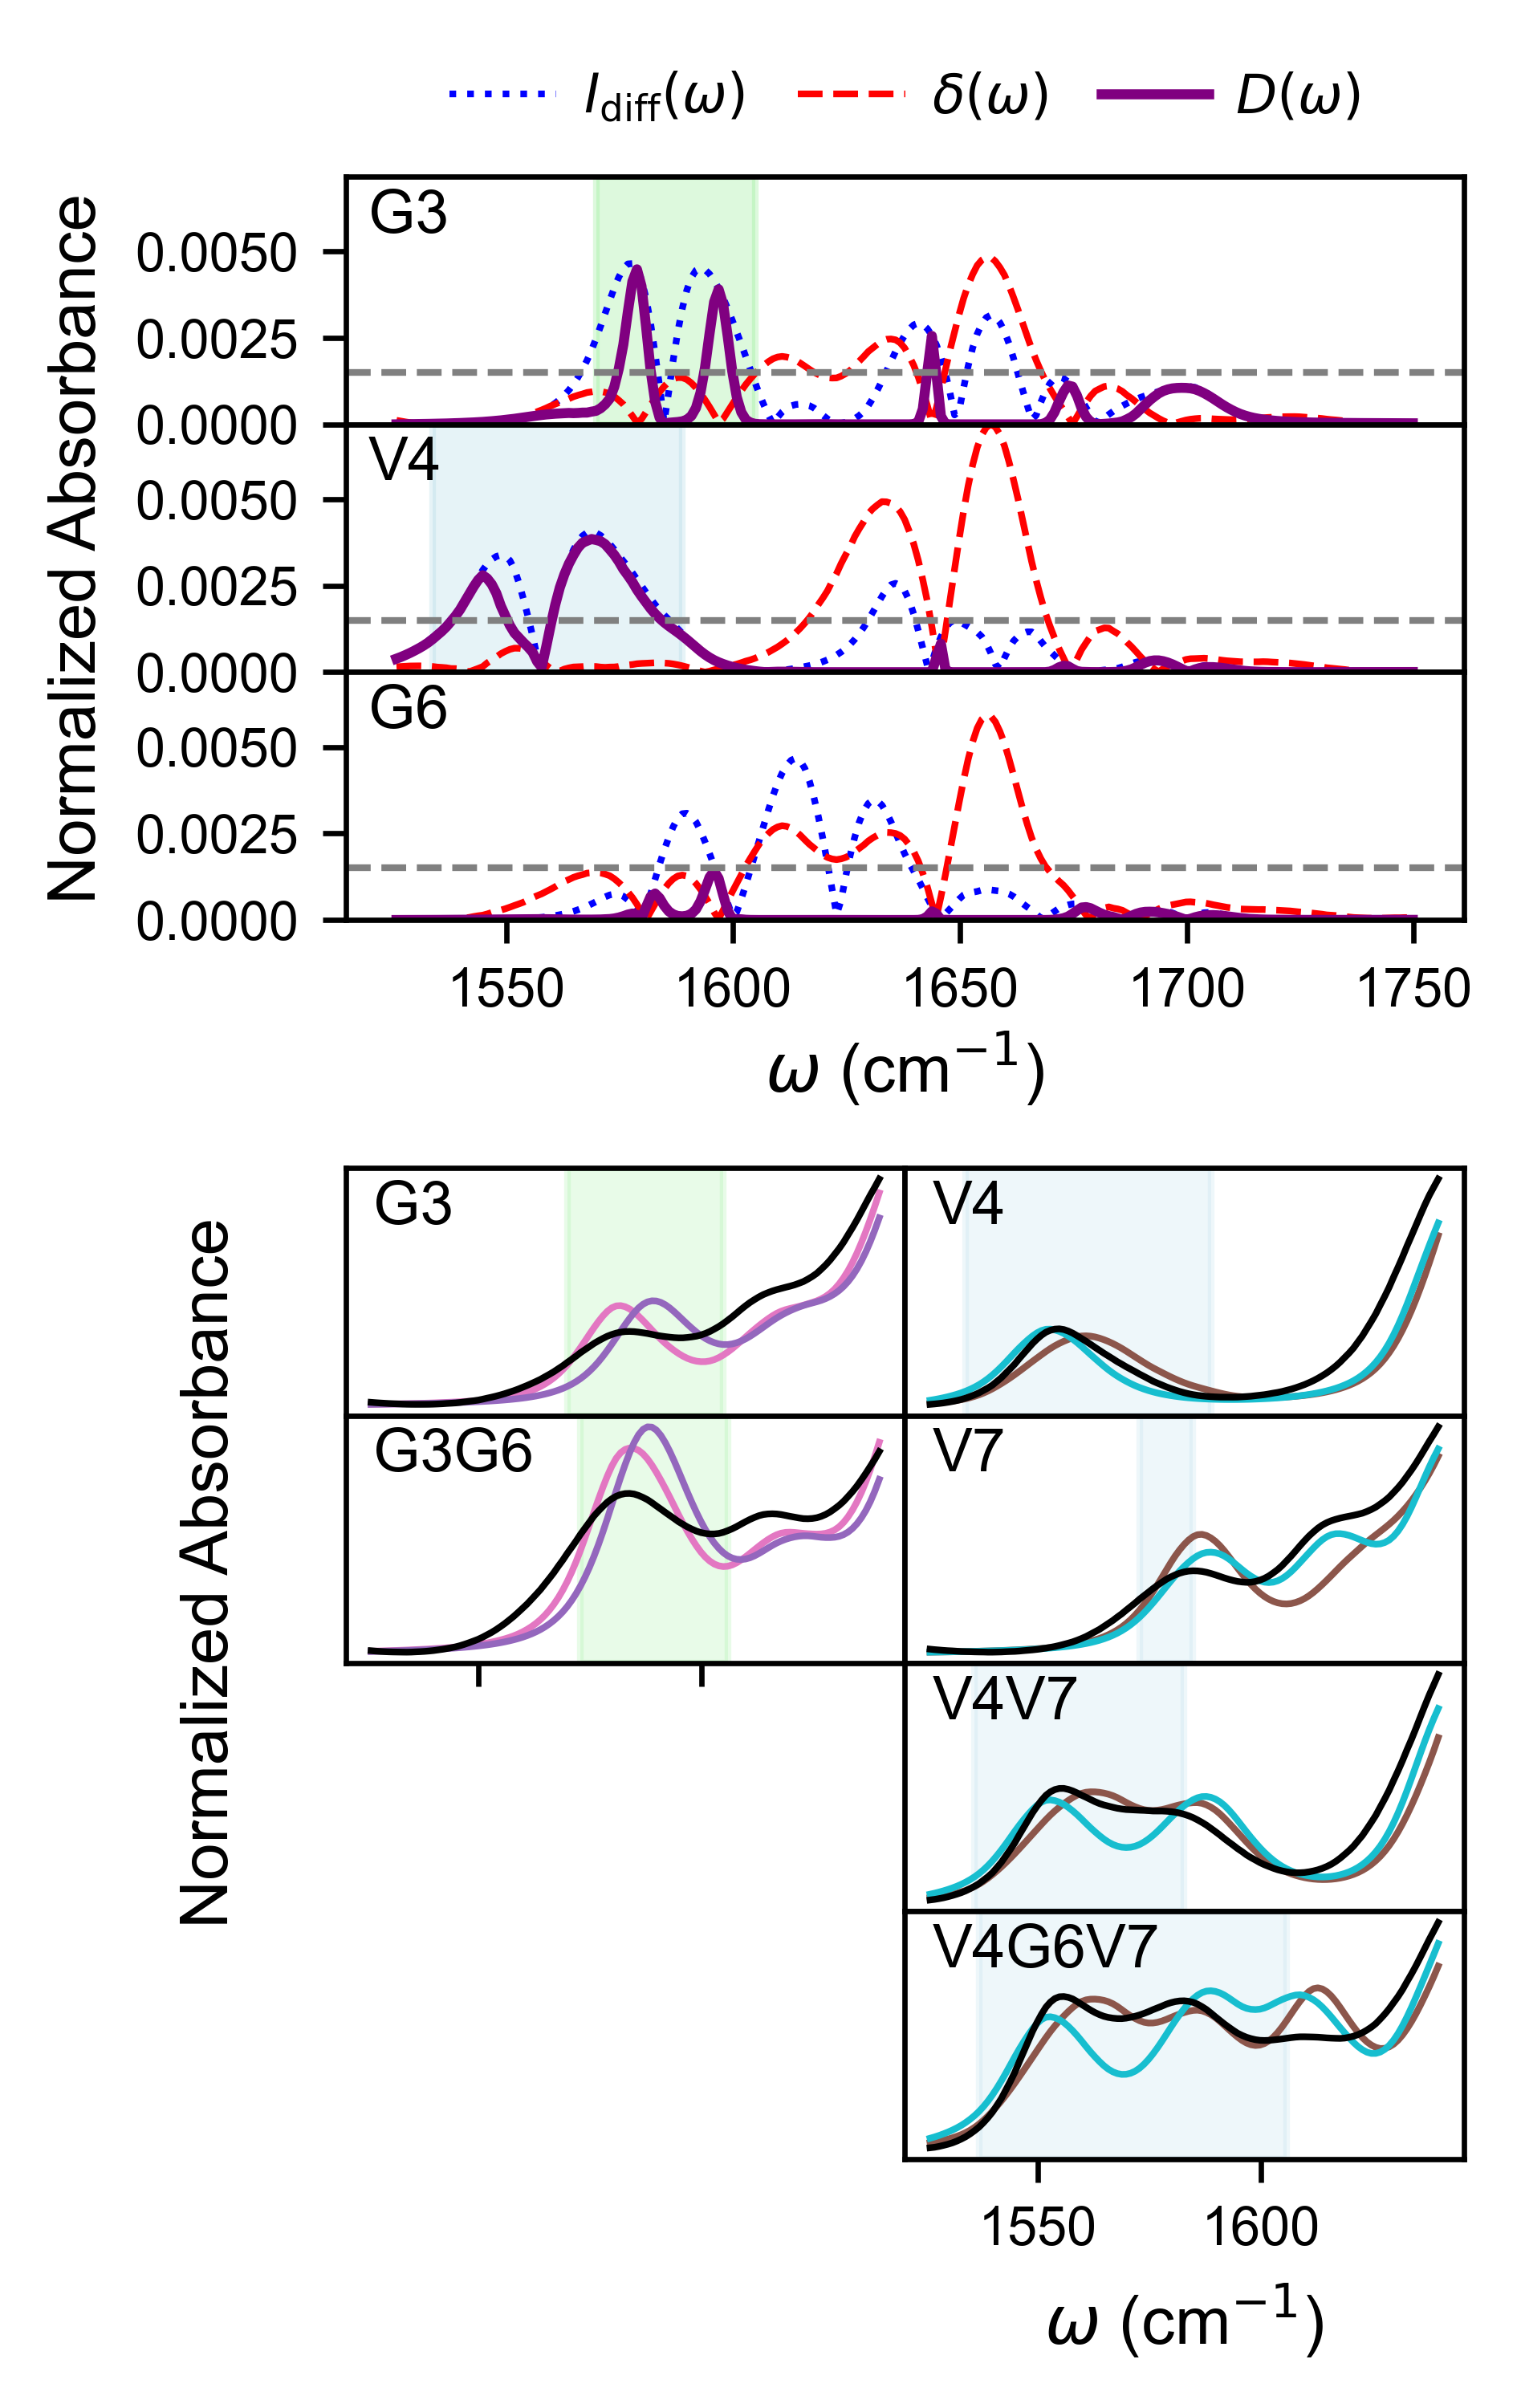


INFORMATIVE REGIONS SUMMARY

C-TURN INFORMATIVE REGIONS:
  V1       (V4      ): 1533.8 - 1588.8 cm⁻¹  (width: 55.0 cm⁻¹)
  V1G3V4   (V4G6V7  ): 1536.8 - 1605.8 cm⁻¹  (width: 69.0 cm⁻¹)
  V1V4     (V4V7    ): 1535.8 - 1582.8 cm⁻¹  (width: 47.0 cm⁻¹)
  V4       (V7      ): 1572.8 - 1584.8 cm⁻¹  (width: 12.0 cm⁻¹)

N-BEND INFORMATIVE REGIONS:
  G5+      (G3      ): 1569.8 - 1604.8 cm⁻¹  (width: 35.0 cm⁻¹)
  G5+G3    (G3G6    ): 1572.8 - 1605.8 cm⁻¹  (width: 33.0 cm⁻¹)


In [1]:
### PLOTS INFORMATIVENESS ANALYSIS (FIG 8) IN MAIN TEXT ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
WAVENUMBERS_FILE = BASE_DIR / 'waxis.txt'
EXP_DIR = BASE_DIR / 'exp_data' / 'processed_FTIRs'
SIM_DIR = BASE_DIR / 'sim_data' / 'sim_spec'
PROP_DIR = BASE_DIR / 'prop_array'

# Data Specifications
FORCE_FIELD = 'CHARMM27_TIP3P'
MAP_TYPE = 'DC1Fnew'

# This maps isotope names to their display labels and file names
# Keys: internal isotope identifiers
# Values: dict with 'label' (what shows on plot) and 'file' (part of filename)
ISOTOPE_MAP = {
    'G3':     {'label': 'G6',   'file': 'G3'},
    'G3+':    {'label': 'G1',   'file': 'G3dag'},
    'G5+':    {'label': 'G3',   'file': 'G5dag'},
    'G5+G3':  {'label': 'G3G6', 'file': 'G5dagG3'},
    'V1':     {'label': 'V4',   'file': 'V1'},
    'V1G3V4': {'label': 'V4G6V7', 'file': 'V1G3V4'},
    'V1V4':   {'label': 'V4V7', 'file': 'V1V4'},
    'V4':     {'label': 'V7',   'file': 'V4'},
    'WT':     {'label': 'UL',   'file': 'WT'},
}

# Analysis Parameters
WAVENUMBER_RANGE = (1525, 1750)  # Range of wavenumbers to load
SPECTRA_PLOT_RANGE = (1525, 1640)  # Range to show in bottom panels
MAX_WAVENUMBER = 1625  # Max wavenumber for informativeness calculation
SIGMA = 0.0005  # Gaussian width for informativeness weighting
DIFF_THRESHOLD = 0.0015  # Threshold for determining "informative" regions
WINDOW_WIDTH = 5  # Width (in cm^-1) for finding contiguous informative regions
PURITY_THRESHOLD = 0.95  # Minimum proportion to consider a "pure" state

# Plotting Specifications
FIGURE_WIDTH = 3.25  # Width in inches
FONT_SIZES = {'labels': 10, 'text': 9, 'ticks': 8, 'legend': 8}
LINE_WIDTH = 1.0

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_wavenumber_axis():
    """
    Load wavenumber axis within analysis range.
    
    Returns:
        wavenumbers: 1D array, shape: (225,)
                    Contains wavenumbers in cm^-1 within WAVENUMBER_RANGE
    """
    # Load full wavenumber axis from file
    wavenumbers = np.loadtxt(WAVENUMBERS_FILE)  # Shape: (full_length,)
    
    # Filter to keep only wavenumbers in our analysis range
    return wavenumbers[(wavenumbers >= WAVENUMBER_RANGE[0]) & 
                       (wavenumbers <= WAVENUMBER_RANGE[1])]

def load_proportions():
    """
    Load proportions array for force field.
    
    Returns:
        proportions: 2D array, shape (5000, 4)
                    Each row is one simulation frame
                    Columns are [C, E, NC, N] state proportions
                    Values in each row sum to 1.0
    """
    filepath = PROP_DIR / FORCE_FIELD / f'proportions_array_0100ps_{FORCE_FIELD}_PAPER.npy'
    return np.load(filepath)

def load_experimental(file_name, wavenumbers):
    """
    Load and normalize experimental spectrum.
    
    Args:
        file_name: str, part of filename (e.g., 'G3', 'V1')
        wavenumbers: 1D array, shape (225,)
    
    Returns:
        spectrum: 1D array, shape (225,)
                 Normalized experimental spectrum
    """
    filepath = EXP_DIR / f'GVGn1_{file_name}_50mgmL_phos_150mM_pH1_basecorr_processed.npy'
    spectrum = np.load(filepath)  # Shape: (225,)
    
    return normalize_by_area(spectrum, wavenumbers)

def load_simulated(name, wavenumbers):
    """
    Load and normalize simulated spectra.
    
    Args:
        name: str, isotope identifier (e.g., 'G3', 'V1')
        wavenumbers: 1D array, shape (225,)
    
    Returns:
        normalized_spectra: 2D array, shape (5000, 225)
                          Each row is a normalized spectrum from one simulation frame
    """
    filepath = SIM_DIR / FORCE_FIELD / f'{MAP_TYPE}_{FORCE_FIELD}_{name}_ftir.npy'
    raw_spectra = np.load(filepath)  # Shape: (5000, 225)
    
    # Baseline correction: subtract minimum from each spectrum
    # np.min(raw_spectra, axis=1) has shape (5000,)
    # [:, None] reshapes to (5000, 1) for broadcasting
    corrected = raw_spectra - np.min(raw_spectra, axis=1)[:, None]
    
    # Normalize each spectrum by its area
    return np.array([normalize_by_area(spectrum, wavenumbers) for spectrum in corrected])

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def normalize_by_area(spectrum, wavenumbers):
    """
    Normalize spectrum by integrated area.
    
    Args:
        spectrum: 1D array, shape (225,)
        wavenumbers: 1D array, shape (225,)
    
    Returns:
        normalized: 1D array, shape (225,)
                   Spectrum normalized so integral = 1
    """
    area = np.trapz(spectrum, x=wavenumbers)  # Scalar value
    return spectrum / area

def compute_state_averages(simulated, proportions, wavenumbers):
    """
    Compute average spectra for pure states.
    
    Args:
        simulated: 2D array, shape (5000, 225)
        proportions: 2D array, shape (5000, 4)
        wavenumbers: 1D array, shape (225,)
    
    Returns:
        averages: list of 4 arrays, each shape (225,)
                 Order: [C, E, NC, N] average spectra
    """
    averages = []
    
    # Process each of the 4 states
    for idx in range(4):  # idx = 0:C, 1:E, 2:NC, 3:N
        # Find frames where this state has high proportion
        mask = proportions[:, idx] > PURITY_THRESHOLD  # Shape: (5000,) boolean
        
        if np.any(mask):
            # Average spectra from "pure" frames
            # simulated[mask] has shape (n_pure_frames, 225)
            avg = normalize_by_area(np.mean(simulated[mask], axis=0), wavenumbers)
        else:
            # No pure frames found
            avg = np.zeros_like(wavenumbers)
        
        averages.append(avg)  # Each avg has shape (225,)
    
    return averages

def compute_diff_metrics(C, E, NC, N):
    """
    Compute difference metrics for C-turn and N-bend features.
    
    Args:
        C, E, NC, N: 1D arrays, each shape (225,)
                     Average spectra for each state
    
    Returns:
        diff_c: 1D array, shape (225,), C-turn difference metric
        diff_n: 1D array, shape (225,), N-bend difference metric
    """
    # C-turn metric: difference between states with/without C-turn
    diff_c = np.abs((C + NC) - (E + N))  # Shape: (225,)
    
    # N-bend metric: difference between states with/without N-bend
    diff_n = np.abs((N + NC) - (E + C))  # Shape: (225,)
    
    return diff_c, diff_n

def compute_abs_diff(experimental, simulated_mean, wavenumbers):
    """
    Compute absolute difference between experimental and simulated.
    
    Args:
        experimental: 1D array, shape (225,)
        simulated_mean: 1D array, shape (225,)
        wavenumbers: 1D array, shape (225,)
    
    Returns:
        delta: 1D array, shape (225,)
               Absolute difference at each wavenumber
    """
    return np.abs(experimental - normalize_by_area(simulated_mean, wavenumbers))

def compute_informativeness(diff, delta):
    """
    Compute informativeness metric D(ω) = I_diff(ω) * exp( -\delta**2 / 2*sigma**2 )
    
    Args:
        diff: 1D array, shape (225,), structural difference
        delta: 1D array, shape (225,), exp-sim difference
    
    Returns:
        informativeness: 1D array, shape (225,)
    """
    return diff * np.exp(-delta**2 / (2 * SIGMA**2))

def find_informative_range(informativeness, wavenumbers):
    """
    Find wavenumber range where informativeness exceeds threshold.
    
    Args:
        informativeness: 1D array, shape (225,)
        wavenumbers: 1D array, shape (225,)
    
    Returns:
        range_tuple: tuple (min_wavenumber, max_wavenumber) or None
    """
    # Find indices where informativeness is high AND wavenumber < MAX
    mask = (wavenumbers < MAX_WAVENUMBER) & (informativeness > DIFF_THRESHOLD)
    indices = np.where(mask)[0]  # Shape: (n_informative,)
    
    if len(indices) == 0:
        return None
    
    # Find all indices within WINDOW_WIDTH (5 cm^-1) of any informative index
    keep = [] # Empty list to store indices we want to keep
    for idx in range(len(wavenumbers)): # Loop through ALL wavenumber indices
        if wavenumbers[idx] < MAX_WAVENUMBER:
            #n p.abs() gets absolute difference between current wavenumber and ALL informative wavenumbers
            # np.any() returns True if ANY of those differences is <= 5 cm^-1
            if np.any(np.abs(wavenumbers[indices] - wavenumbers[idx]) <= WINDOW_WIDTH):
                keep.append(idx)
    
    if keep:  # If keep list is not empty
    # min(keep) = leftmost index, max(keep) = rightmost index
    # Convert back to actual wavenumber values and return as tuple
        return (wavenumbers[min(keep)], wavenumbers[max(keep)])
    return None

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for publication figures."""
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': FONT_SIZES['labels'],
        'axes.labelsize': FONT_SIZES['labels'],
        'axes.titlesize': FONT_SIZES['labels'],
        'xtick.labelsize': FONT_SIZES['ticks'],
        'ytick.labelsize': FONT_SIZES['ticks'],
        'legend.fontsize': FONT_SIZES['legend'],
        'figure.titlesize': FONT_SIZES['labels']
    })

def plot_informativeness(ax, wavenumbers, diff, delta, label, highlight_range, is_n_turn=False):
    """
    Plot informativeness analysis for isotope.
    This creates the TOP 3 PANELS showing the mathematical analysis.
    
    Args:
        ax: matplotlib axes object
        wavenumbers: 1D array, shape (225,)
        diff: 1D array, shape (225,), structural difference I_diff
        delta: 1D array, shape (225,), exp-sim difference δ
        label: str, isotope label to display (e.g., 'G6', 'V4')
        highlight_range: tuple (min, max) or None, informative region
        is_n_turn: bool, True for N-bend analysis, False for C-turn
    """
    # Compute informativeness D(ω)
    informativeness = compute_informativeness(diff, delta)  # Shape: (225,)
    
    # Plot three curves:
    # 1. Blue dotted: structural difference I_diff(ω)
    ax.plot(wavenumbers, diff, 'b:', lw=LINE_WIDTH, label=r'$I_{\mathrm{diff}}(\omega)$')
    
    # 2. Red dashed: experimental-simulation difference δ(ω)
    ax.plot(wavenumbers, delta, 'r--', lw=LINE_WIDTH, label=r'$\delta(\omega)$')
    
    # 3. Purple solid: informativeness D(ω) = I_diff × exp(-δ²/2σ²)
    ax.plot(wavenumbers, informativeness, color='purple', lw=LINE_WIDTH * 1.5, label=r'$D(\omega)$')
    
    # Horizontal line showing threshold for "informative" regions
    ax.axhline(DIFF_THRESHOLD, color='gray', ls='--', lw=LINE_WIDTH)
    
    # Highlight informative region if found
    if highlight_range:
        # Green for N-bend, blue for C-turn
        color = 'lightgreen' if is_n_turn else 'lightblue'
        ax.axvspan(*highlight_range, color=color, alpha=0.3)
    
    # Add isotope label in top-left corner
    ax.text(0.02, 0.95, label, transform=ax.transAxes, fontsize=FONT_SIZES['text'], va='top')

def plot_spectra_comparison(ax, wavenumbers, experimental, C, E, NC, N, highlight_range, label, is_n_turn=False):
    """
    Plot spectral comparison for isotope.
    This creates the BOTTOM PANELS showing actual spectra.
    
    Args:
        ax: matplotlib axes object
        wavenumbers: 1D array, shape (plotting range,) - only plotting range (subset of 225)
        experimental: 1D array, shape (plotting range,)
        C, E, NC, N: 1D arrays, shape (plotting range,), state spectra
        highlight_range: tuple (min, max) or None
        label: str, isotope label
        is_n_turn: bool, True for N-bend (left column), False for C-turn (right column)
    """
    if is_n_turn:  # N-bend analysis (LEFT COLUMN)
        # Average states WITHOUT N-bend (C+E) vs WITH N-bend (NC+N)
        avg1, avg2 = (C + E) / 2, (NC + N) / 2  # Shape: (225_subset,)
        label1, color1 = 'C + E (avg)', '#e377c2'  # Pink
        label2, color2 = 'NC + N (avg)', '#9467bd'  # Purple
        highlight_color = 'lightgreen'
    else:  # C-turn analysis (RIGHT COLUMN)
        # Average states WITHOUT C-turn (E+N) vs WITH C-turn (C+NC)
        avg1, avg2 = (C + NC) / 2, (E + N) / 2  # Shape: (225_subset,)
        label1, color1 = 'C + NC (avg)', '#8c564b'  # Brown
        label2, color2 = 'E + N (avg)', '#17becf'  # Cyan
        highlight_color = 'lightblue'

    # Plot the averaged simulated spectra
    ax.plot(wavenumbers, avg1, color=color1, lw=LINE_WIDTH, label=label1)
    ax.plot(wavenumbers, avg2, color=color2, lw=LINE_WIDTH, label=label2)
    
    # Plot experimental spectrum in black
    ax.plot(wavenumbers, experimental, color='black', lw=LINE_WIDTH, label='Experimental')
    
    # Highlight informative region if present
    if highlight_range:
        ax.axvspan(*highlight_range, color=highlight_color, alpha=0.2)
    
    # Add isotope label in top-left corner
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=FONT_SIZES['text'], 
            va='top', ha='left')

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """
    Main function to generate the plot.
    FIGURE LAYOUT:
    - Top 3 rows: Informativeness analysis for G5+, V1, G3
    - Row 4: Spacer (height 0.7 relative to others)
    - Bottom rows: Two columns of spectra plots
      - Left column: N-bend analysis (G5+, G5+G3)
      - Right column: C-turn analysis (V1, V4, V1V4, V1G3V4)
    """
    set_plot_style()
    
    # Load common data
    wavenumbers = load_wavenumber_axis()  # Shape: (225,)
    proportions = load_proportions()      # Shape: (5000, 4)
    
    # Process all isotopes
    results = {}       # Will store all computed data
    ranges_c, ranges_n = {}, {}  # Will store informative ranges
    
    for name, info in ISOTOPE_MAP.items():
        #ISOTOPE_MAP = {
        #'G3':     {'label': 'G6',   'file': 'G3'},
        # ...}
        try:
            # Load data for this isotope
            experimental = load_experimental(info['file'], wavenumbers)  # Shape: (225,)
            simulated = load_simulated(name, wavenumbers)  # Shape: (5000, 225)
            
            # Compute average spectra for each state
            C, E, NC, N = compute_state_averages(simulated, proportions, wavenumbers)
            # Each of the 4 is shape (225,)
            
            # Compute difference metrics
            delta = compute_abs_diff(experimental, np.mean(simulated, axis=0), wavenumbers)
            diff_c, diff_n = compute_diff_metrics(C, E, NC, N)
            # Each of the 2 is shape (225,)
            
            # Find informative ranges
            D_c = compute_informativeness(diff_c, delta)  # Shape: (225,)
            D_n = compute_informativeness(diff_n, delta)  # Shape: (225,)
            range_c = find_informative_range(D_c, wavenumbers)  # tuple or None
            range_n = find_informative_range(D_n, wavenumbers)  # tuple or None
            
            # Store all results
            results[name] = {
                'experimental': experimental, 'C': C, 'E': E, 'NC': NC, 'N': N,
                'delta': delta, 'diff_c': diff_c, 'diff_n': diff_n
            }
            
            # Store ranges if found
            if range_c:
                ranges_c[name] = range_c
            if range_n:
                ranges_n[name] = range_n
                
        except FileNotFoundError as e:
            print(f"ERROR {name} not found: {e}")
    
    # Define which isotopes go in which panels
    info_names = ['G5+', 'V1', 'G3']  # Top 3 panels (informativeness plots)
    
    # Bottom panels: only show isotopes that have informative ranges
    c_names = [n for n in ['V1', 'V4', 'V1V4', 'V1G3V4'] if n in ranges_c]  # Right column
    n_names = [n for n in ['G5+', 'G5+G3'] if n in ranges_n]  # Left column
    
    # Calculate figure dimensions
    nrows = max(len(c_names), len(n_names))  # Number of bottom panel rows
    fig_height = 0.7 * 3 + 0.2 + 0.7 * nrows  # Heights: 3 top (0.7) + spacer (0.2) + bottom panels (0.7*nrows)
    
    # Create figure with GridSpec for complex layout
    fig = plt.figure(figsize=(FIGURE_WIDTH, fig_height), dpi=600)
    total_rows = 3 + 1 + nrows  # 3 top + 1 spacer + bottom panels
    height_ratios = [1, 1, 1] + [1] + [1] * nrows  # Spacer is 1 height
    
    # Create grid: total_rows × 2 columns
    gs = fig.add_gridspec(total_rows, 2, height_ratios=height_ratios, hspace=0, wspace=0)
    
    # === TOP 3 PANELS: Informativeness Analysis ===
    # Calculate y-axis limits to be same for all 3 panels
    all_y_vals = []
    for name in info_names:
        d = results[name]
        diff = d['diff_n'] if name == 'G5+' else d['diff_c'] # already in dictionary
        D = compute_informativeness(diff, d['delta'])
        # Collect all y-values to find global min/max for plotting purposes
        all_y_vals.extend([np.min(diff), np.max(diff), np.min(d['delta']), 
                          np.max(d['delta']), np.min(D), np.max(D)])
    ymin, ymax = np.min(all_y_vals), np.max(all_y_vals)
    
    # Plot top 3 panels
    for idx, name in enumerate(info_names):
        # Each top panel spans both columns: gs[row, :]
        ax = fig.add_subplot(gs[idx, :])
        
        d = results[name]
        is_n = (name == 'G5+')  # G5+ uses N-bend analysis, others use C-turn
        diff = d['diff_n'] if is_n else d['diff_c']
        highlight = ranges_n.get(name) if is_n else ranges_c.get(name) # already in dictionary
        
        plot_informativeness(ax, wavenumbers, diff, d['delta'], 
                           ISOTOPE_MAP[name]['label'], highlight, is_n_turn=is_n) # Boolean control for G5+
        ax.set_ylim(ymin, ymax)  # Same scale for all 3 panels as found earlier
        
        # Only middle panel gets y-label
        if idx == 1:
            ax.set_ylabel("Normalized Absorbance", fontsize=FONT_SIZES['labels'])
        
        # Only bottom panel gets x-label and x-ticks
        if idx == 2:
            ax.set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=FONT_SIZES['labels'], labelpad=2)
        if idx < 2:
            ax.tick_params(labelbottom=False)  # Hide x-ticks for top 2 panels
        
        # Only top panel gets legend
        if idx == 0:
            # Get the legend handles and labels
            handles, labels = ax.get_legend_handles_labels()
            
            # Place legend above the plot area
            # bbox_to_anchor: (x, y) where (0.5, 1.0) centers it horizontally at the top
            # The y-value > 1.0 places it above the axes
            ax.legend(handles, labels, 
                      loc='lower center',           # Anchor point of legend box
                      bbox_to_anchor=(0.5, 1.02),   # Position relative to axes
                      ncol=3,                       # 3 columns for the 3 items
                      fontsize=FONT_SIZES['ticks'], 
                      frameon=False,                # No frame around legend
                      columnspacing=1.0,            # Space between columns
                      handletextpad=0.5)            # Space between marker and text
    
    # === BOTTOM PANELS: Spectra Comparisons ===
    # Filter wavenumbers to plotting range
    mask = (wavenumbers >= SPECTRA_PLOT_RANGE[0]) & (wavenumbers <= SPECTRA_PLOT_RANGE[1])
    # wavenumbers[mask] has shape (~115,) - subset for plotting
    
    # Plot bottom panels in 2 columns
    for idx in range(nrows):
        # LEFT COLUMN: N-bend analysis
        ax_left = fig.add_subplot(gs[4 + idx, 0])  # Row 4+idx, column 0
        
        if idx < len(n_names):
            # Plot N-bend isotopes
            name = n_names[idx]
            r = results[name]
            plot_spectra_comparison(ax_left, wavenumbers[mask], r['experimental'][mask],
                                  r['C'][mask], r['E'][mask], r['NC'][mask], r['N'][mask],
                                  ranges_n[name], ISOTOPE_MAP[name]['label'], is_n_turn=True)
        else:
            # Empty subplot
            ax_left.axis('off')
        
        ax_left.set_yticks([])  # No y-ticks
        if idx < nrows - 1:
            ax_left.tick_params(labelbottom=False)  # No x-ticks except bottom row
        else:
            ax_left.set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=FONT_SIZES['labels'])
        
        # RIGHT COLUMN: C-turn analysis
        ax_right = fig.add_subplot(gs[4 + idx, 1])  # Row 4+idx, column 1
        
        if idx < len(c_names):
            # Plot C-turn isotope
            name = c_names[idx]
            r = results[name]
            plot_spectra_comparison(ax_right, wavenumbers[mask], r['experimental'][mask],
                                  r['C'][mask], r['E'][mask], r['NC'][mask], r['N'][mask],
                                  ranges_c[name], ISOTOPE_MAP[name]['label'], is_n_turn=False)
        else:
            # Empty subplot
            ax_right.axis('off')
        
        ax_right.set_yticks([])  # No y-ticks
        if idx < nrows - 1:
            ax_right.tick_params(labelbottom=False)  # No x-ticks except bottom row
        else:
            ax_right.set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=FONT_SIZES['labels'])
    
    # Add y-axis label for bottom panels (rotated, on left side)
    fig.text(0.15, 0.35, 'Normalized Absorbance', rotation=90, 
             fontsize=FONT_SIZES['labels'], ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary of informative regions
    print("\n" + "="*70)
    print("INFORMATIVE REGIONS SUMMARY")
    print("="*70)
    
    # C-turn regions
    print("\nC-TURN INFORMATIVE REGIONS:")
    if ranges_c:
        for name in sorted(ranges_c.keys()):
            start, end = ranges_c[name]
            label = ISOTOPE_MAP[name]['label']
            width = end - start
            print(f"  {name:<8} ({label:<8}): {start:6.1f} - {end:6.1f} cm⁻¹  (width: {width:4.1f} cm⁻¹)")
    else:
        print("  None found")
    
    # N-bend regions
    print("\nN-BEND INFORMATIVE REGIONS:")
    if ranges_n:
        for name in sorted(ranges_n.keys()):
            start, end = ranges_n[name]
            label = ISOTOPE_MAP[name]['label']
            width = end - start
            print(f"  {name:<8} ({label:<8}): {start:6.1f} - {end:6.1f} cm⁻¹  (width: {width:4.1f} cm⁻¹)")
    else:
        print("  None found")

# RUN

if __name__ == "__main__":
    main()

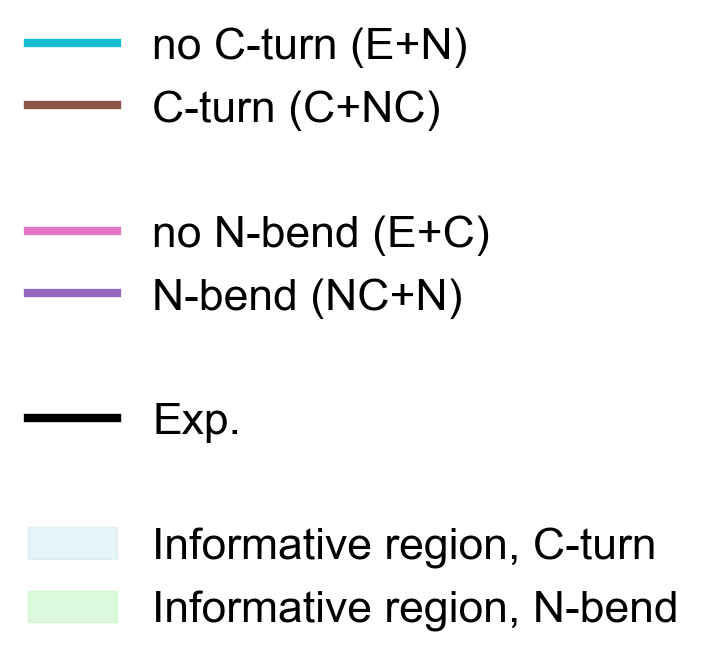

In [2]:
import matplotlib.patches as patches

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

# Define the colors and labels used in the main plot (updated with colorblind-friendly palette)
legend_entries = [
    ("no C-turn (E+N)", "#17becf", "line"),     # Cyan
    ("C-turn (C+NC)", "#8c564b", "line"),       # Brown
    ("", "white", "line"),                       # Spacer
    ("no N-bend (E+C)", "#e377c2", "line"),     # Pink
    ("N-bend (NC+N)", "#9467bd", "line"),       # Purple
    ("", "white", "line"),                       # Spacer
    ("Exp.", "black", "line"),                   # Black
    ("", "white", "line"),                       # Spacer
    ("Informative region, C-turn", "lightblue", "patch"),   # Blue shading
    ("Informative region, N-bend", "lightgreen", "patch"),  # Green shading
]

# Create a figure for the legend
fig_legend = plt.figure(figsize=(8, 2.5))  # Increased height for additional entries
ax = fig_legend.add_subplot(111)
ax.axis("off")  # Remove axes

# Generate legend handles
handles = []
labels = []

for label, color, handle_type in legend_entries:
    if handle_type == "line":
        handles.append(plt.Line2D([0], [0], color=color, linewidth=6, linestyle='-'))
    elif handle_type == "patch":
        handles.append(patches.Patch(color=color, alpha=0.3))  # Match the alpha used in the main plot
    
    labels.append(label)

# Create legend without border
legend = ax.legend(
    handles,
    labels,
    loc='center',
    fontsize=32,
    frameon=False,  # Remove frame (no border)
)

# Ensure legend text is Arial
for text in legend.get_texts():
    text.set_fontfamily('Arial')

# Display the legend
plt.show()